In [8]:
import cv2
import pandas as pd

final_data_path = open("final_features.txt", "r")
final_data_pre = pd.read_csv(final_data_path.read().strip())

# create a new DF
def load_feature_file(filename: str) -> list[float]:
    with open(filename, 'r') as file:
        file_content = file.read()
        res = [float(item) for item in file_content.split(',')]
        return res

final_data_pre["LABEL"] = final_data_pre["class_name"]
final_data_pre["FEATURES"] = final_data_pre["file_path"].map(load_feature_file)

Convert from dataset format to
LABEL, FEATURES
"LABEL1", [1,2,3,......]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(final_data_pre)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe

print("Original DataFrame head:")
print(df.head())

# --- 2. EXTRACT FEATURES AND LABELS FROM DATAFRAME ---
# Convert the list of features into a 2D NumPy array
# Using .tolist() or .values is efficient for this.
features = np.array(df['FEATURES'].tolist()).astype(np.float32)

# Get the string labels
labels = df['LABEL'].values

# --- 3. MAP STRING LABELS TO INTEGERS ---
# This part is the same as before
unique_classes = np.unique(labels)
num_classes = len(unique_classes)
class_names = np.unique(labels)
class_to_idx = {class_name: i for i, class_name in enumerate(unique_classes)}
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

# Convert string labels to integer labels using the map
integer_labels = np.array([class_to_idx[label] for label in labels])

print(f"\nClass Mapping: {class_to_idx}")

# --- 4. PREPROCESS AND SPLIT DATA ---
X_train, X_val, y_train, y_val = train_test_split(
    features, integer_labels, test_size=0.2, random_state=42, stratify=integer_labels
)

# It's crucial to scale your features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# --- 5. CREATE PYTORCH DATASET AND DATALOADERS ---
# This part is also unchanged.
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Get the number of features from the data shape
num_features = features.shape[1]

# It's crucial t

Original DataFrame head:
                                     id         class_name  \
0  2abbead6a19916a89acaeb9c1b9749f2.png  avocado_firm_self   
1  fee61db975e543b504702c6a00007bfa.png  avocado_ripe_self   
2  88db598b3e1415951980ffb68e17350d.png  avocado_firm_self   
3  ea16d52cfce6b2e49ff5468989ddb578.png  avocado_firm_self   
4  04cf9f75ed3bf0d2240c729f3ad30f6e.png  avocado_firm_self   

                                           file_path resolution  \
0  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
1  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
2  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
3  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
4  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   

               LABEL                                           FEATURES  
0  avocado_firm_self  [0.9653940796852112, 0.046972233802080154, 0.6...  
1  avocado_ripe_self  [2.425001382827759, 0.3151375

In [10]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(SimpleClassifier, self).__init__()
        # Adjust hidden layer sizes based on your number of features if needed
        self.layer1 = nn.Linear(input_features, 64) 
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 48)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(48, 128)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Instantiate the model
model = SimpleClassifier(input_features=num_features, num_classes=num_classes)
print(f"\nModel Architecture:\n{model}")


Model Architecture:
SimpleClassifier(
  (layer1): Linear(in_features=2048, out_features=64, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=64, out_features=48, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=48, out_features=128, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=128, out_features=12, bias=True)
)


In [11]:
# --- STEP 3: LOSS AND OPTIMIZER (Identical) ---
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- STEP 4: TRAINING LOOP (Identical) ---
num_epochs = 20
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Simple validation check at the end of each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%")

print("\nFinished Training!")

Epoch [1/20], Loss: 0.4415, Validation Accuracy: 86.37%
Epoch [2/20], Loss: 0.1179, Validation Accuracy: 91.68%
Epoch [3/20], Loss: 0.1360, Validation Accuracy: 94.55%
Epoch [4/20], Loss: 0.0773, Validation Accuracy: 95.98%
Epoch [5/20], Loss: 0.0133, Validation Accuracy: 95.98%
Epoch [6/20], Loss: 0.0787, Validation Accuracy: 96.41%
Epoch [7/20], Loss: 0.0150, Validation Accuracy: 95.98%
Epoch [8/20], Loss: 0.0184, Validation Accuracy: 96.99%
Epoch [9/20], Loss: 0.0386, Validation Accuracy: 97.56%
Epoch [10/20], Loss: 0.0104, Validation Accuracy: 97.99%
Epoch [11/20], Loss: 0.0565, Validation Accuracy: 97.85%
Epoch [12/20], Loss: 0.0008, Validation Accuracy: 97.70%
Epoch [13/20], Loss: 0.0382, Validation Accuracy: 97.56%
Epoch [14/20], Loss: 0.0033, Validation Accuracy: 97.85%
Epoch [15/20], Loss: 0.0468, Validation Accuracy: 98.28%
Epoch [16/20], Loss: 0.0188, Validation Accuracy: 98.28%
Epoch [17/20], Loss: 0.0013, Validation Accuracy: 98.28%
Epoch [18/20], Loss: 0.0019, Validation 

In [12]:
# Example of a new data point (a list of 15 numbers)
new_feature_list = np.random.rand(2048).tolist()

# 1. Convert to NumPy array and reshape for the scaler
new_feature_np = np.array([new_feature_list], dtype=np.float32)

# 2. Scale it using the saved scaler
scaled_new_feature = scaler.transform(new_feature_np)

# 3. Convert to a PyTorch tensor
feature_tensor = torch.tensor(scaled_new_feature, dtype=torch.float32)

# 4. Predict
model.eval()
with torch.no_grad():
    output = model(feature_tensor)
    predicted_index = torch.argmax(output, dim=1).item()
    predicted_label = idx_to_class[predicted_index]

print(f"\nNew data point's predicted label: '{predicted_label}'")


New data point's predicted label: 'alpukat_ripe_google'


In [13]:
# --- 5. VISUALIZE PREDICTIONS ---

def show_predictions(model, loader, idx_to_class_map, num_to_show=5):
    """
    Runs the model on data from the loader and prints predictions vs. actual labels.
    """
    model.eval()  # Set the model to evaluation mode
    
    predictions_shown = 0
    print(f"Showing predictions for the first {num_to_show} samples...")
    
    # We use torch.no_grad() to stop tracking gradients, which is faster for inference
    with torch.no_grad():
        # Iterate through the data loader
        for features, labels in loader:
            # Get model outputs
            outputs = model(features)
            
            # Get the predicted class index (the one with the highest score)
            _, predicted_indices = torch.max(outputs, 1)
            
            # Loop through the batch
            for i in range(features.shape[0]):
                if predictions_shown >= num_to_show:
                    return # Exit the function once we've shown enough
                
                # Get the actual and predicted labels as strings
                actual_label = idx_to_class_map[labels[i].item()]
                predicted_label = idx_to_class_map[predicted_indices[i].item()]
                
                # Check if the prediction was correct and add a visual marker
                status = "✅ Correct" if actual_label == predicted_label else "❌ Incorrect"
                
                print(f"  Sample {predictions_shown + 1}: Actual: {actual_label:<8} | Predicted: {predicted_label:<8} | Status: {status}")
                
                predictions_shown += 1

# --- Now, call the function for both training and validation data ---

print("--- Predictions on Training Data ---")
# We shuffle the train_loader, so these will be random training samples
show_predictions(model, train_loader, idx_to_class, num_to_show=20)

print("\n--- Predictions on Test/Validation Data ---")
# These are samples the model did not directly train on in the same epoch
show_predictions(model, val_loader, idx_to_class, num_to_show=20)

--- Predictions on Training Data ---
Showing predictions for the first 20 samples...
  Sample 1: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: ✅ Correct
  Sample 2: Actual: banana_day5_self | Predicted: banana_day5_self | Status: ✅ Correct
  Sample 3: Actual: banana_day3_self | Predicted: banana_day3_self | Status: ✅ Correct
  Sample 4: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: ✅ Correct
  Sample 5: Actual: avocado_ripe_self | Predicted: avocado_ripe_self | Status: ✅ Correct
  Sample 6: Actual: banana_day4_self | Predicted: banana_day4_self | Status: ✅ Correct
  Sample 7: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: ✅ Correct
  Sample 8: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: ✅ Correct
  Sample 9: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: ✅ Correct
  Sample 10: Actual: avocado_ripe_self | Predicted: avocado_ripe_self | Status: ✅ Correct
  Sample 11: Actual: avocado_f

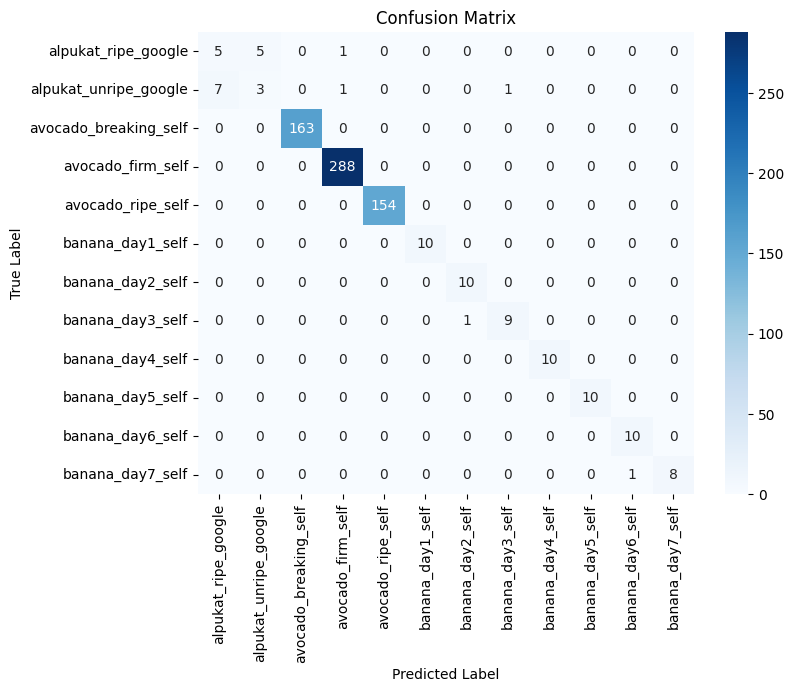

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# --- 5. GENERATE AND VISUALIZE CONFUSION MATRIX ---

# Lists to store all true labels and predictions from the validation set
all_labels = []
all_predictions = []

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Turn off gradients for inference
    for features, labels in val_loader:
        # Get model outputs
        outputs = model(features)
        
        # Get predicted class indices
        _, predicted = torch.max(outputs, 1)
        
        # Append batch predictions and labels to the lists
        # .cpu() is used to move data to the CPU if you are using a GPU
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix using scikit-learn
cm = confusion_matrix(all_labels, all_predictions)

# Create a figure and an axes for the plot
plt.figure(figsize=(8, 6))

# Use seaborn to create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

# Add labels and a title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()